In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install jovian --upgrade --quiet

In [15]:
import torch
import jovian
import torchvision
import matplotlib
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [69]:
project_name='02-Wine-Quality-Prediction' # will be used by jovian.commit

In [9]:
dataframe_raw = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")
dataframe_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
dataframe_raw.shape

(1599, 12)

In [11]:
input_cols=list(dataframe_raw.columns)[:-1]
output_cols = ['quality']
input_cols,output_cols

(['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol'],
 ['quality'])

In [17]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe_raw.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    #for col in categorical_cols:
        #dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [20]:
inputs_array, targets_array = dataframe_to_arrays(dataframe_raw)
inputs_array, targets_array

(array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
        [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
        [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
        ...,
        [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
        [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
        [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]]),
 array([[5],
        [5],
        [5],
        ...,
        [6],
        [5],
        [6]]))

In [22]:
inputs = torch.from_numpy(inputs_array).type(torch.float)
targets = torch.from_numpy(targets_array).type(torch.float)
inputs,targets

(tensor([[ 7.4000,  0.7000,  0.0000,  ...,  3.5100,  0.5600,  9.4000],
         [ 7.8000,  0.8800,  0.0000,  ...,  3.2000,  0.6800,  9.8000],
         [ 7.8000,  0.7600,  0.0400,  ...,  3.2600,  0.6500,  9.8000],
         ...,
         [ 6.3000,  0.5100,  0.1300,  ...,  3.4200,  0.7500, 11.0000],
         [ 5.9000,  0.6450,  0.1200,  ...,  3.5700,  0.7100, 10.2000],
         [ 6.0000,  0.3100,  0.4700,  ...,  3.3900,  0.6600, 11.0000]]),
 tensor([[5.],
         [5.],
         [5.],
         ...,
         [6.],
         [5.],
         [6.]]))

In [30]:
print('Shape of input tensor and target tensor::  ',inputs.shape, targets.shape)
print('datatype of input tensor and target tensor::  ',inputs.dtype, targets.dtype)

Shape of input tensor and target tensor::   torch.Size([1599, 11]) torch.Size([1599, 1])
datatype of input tensor and target tensor::   torch.float32 torch.float32


In [33]:
dataset = TensorDataset(inputs, targets)
dataset

In [34]:
train_ds, val_ds = random_split(dataset, [1300, 299])
batch_size=50
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [35]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[9.3000e+00, 4.0000e-01, 4.9000e-01, 2.5000e+00, 8.5000e-02, 3.8000e+01,
         1.4200e+02, 9.9780e-01, 3.2200e+00, 5.5000e-01, 9.4000e+00],
        [1.1600e+01, 5.3000e-01, 6.6000e-01, 3.6500e+00, 1.2100e-01, 6.0000e+00,
         1.4000e+01, 9.9780e-01, 3.0500e+00, 7.4000e-01, 1.1500e+01],
        [7.9000e+00, 5.4500e-01, 6.0000e-02, 4.0000e+00, 8.7000e-02, 2.7000e+01,
         6.1000e+01, 9.9650e-01, 3.3600e+00, 6.7000e-01, 1.0700e+01],
        [6.8000e+00, 6.6000e-01, 7.0000e-02, 1.6000e+00, 7.0000e-02, 1.6000e+01,
         6.1000e+01, 9.9572e-01, 3.2900e+00, 6.0000e-01, 9.3000e+00],
        [1.0300e+01, 2.7000e-01, 5.6000e-01, 1.4000e+00, 4.7000e-02, 3.0000e+00,
         8.0000e+00, 9.9471e-01, 3.1600e+00, 5.1000e-01, 1.1800e+01],
        [1.0200e+01, 4.4000e-01, 4.2000e-01, 2.0000e+00, 7.1000e-02, 7.0000e+00,
         2.0000e+01, 9.9566e-01, 3.1400e+00, 7.9000e-01, 1.1100e+01],
        [1.0000e+01, 4.6000e-01, 4.4000e-01, 2.9000e+00, 6.5000e-02, 4.0000e+00,
     

In [38]:
 print(xb.dtype,yb.dtype)

torch.float32 torch.float32


In [39]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size,output_size

(11, 1)

In [46]:
class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,output_size) #???                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb): 
        out = self.linear(xb) #???                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out,targets) #???                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out,targets) #???                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 100th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [47]:
model=WineQuality()

In [48]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1463,  0.1563, -0.0537,  0.2641,  0.0985,  0.2435,  0.2640, -0.0668,
           0.1780, -0.2056,  0.2640]], requires_grad=True),
 Parameter containing:
 tensor([0.0162], requires_grad=True)]

In [49]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [50]:
result = evaluate(model, val_loader)#??? # Use the the evaluate function
print(result)

{'val_loss': 15.789398193359375}


In [51]:
epochs = 1000 #???
lr = 1e-2    #???
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 13.5318
Epoch [200], val_loss: 3.7057
Epoch [300], val_loss: 10.4144
Epoch [400], val_loss: 20.0141
Epoch [500], val_loss: 12.0501
Epoch [600], val_loss: 12.4557
Epoch [700], val_loss: 9.1371
Epoch [800], val_loss: 5.6503
Epoch [900], val_loss: 20.3145
Epoch [1000], val_loss: 8.4462


In [52]:
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 1.9420
Epoch [200], val_loss: 0.9745
Epoch [300], val_loss: 0.6104
Epoch [400], val_loss: 1.4688
Epoch [500], val_loss: 1.7100
Epoch [600], val_loss: 1.5763
Epoch [700], val_loss: 1.4629
Epoch [800], val_loss: 1.0126
Epoch [900], val_loss: 1.5602
Epoch [1000], val_loss: 1.8191


In [53]:
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 0.5118
Epoch [200], val_loss: 0.5305
Epoch [300], val_loss: 0.5128
Epoch [400], val_loss: 0.5111
Epoch [500], val_loss: 0.5120
Epoch [600], val_loss: 0.5092
Epoch [700], val_loss: 0.5205
Epoch [800], val_loss: 0.5096
Epoch [900], val_loss: 0.5076
Epoch [1000], val_loss: 0.5074


In [54]:
epochs = 1000
lr = 1e-5
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 0.5077
Epoch [200], val_loss: 0.5083
Epoch [300], val_loss: 0.5081
Epoch [400], val_loss: 0.5084
Epoch [500], val_loss: 0.5077
Epoch [600], val_loss: 0.5077
Epoch [700], val_loss: 0.5082
Epoch [800], val_loss: 0.5077
Epoch [900], val_loss: 0.5080
Epoch [1000], val_loss: 0.5080


In [59]:
#model=WineQuality()
epochs = 1500
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 2.6545
Epoch [200], val_loss: 2.5039
Epoch [300], val_loss: 2.3609
Epoch [400], val_loss: 2.2198
Epoch [500], val_loss: 2.0807
Epoch [600], val_loss: 1.9441
Epoch [700], val_loss: 1.8138
Epoch [800], val_loss: 1.6892
Epoch [900], val_loss: 1.5679
Epoch [1000], val_loss: 1.4524
Epoch [1100], val_loss: 1.3439
Epoch [1200], val_loss: 1.2383
Epoch [1300], val_loss: 1.1367
Epoch [1400], val_loss: 1.0420
Epoch [1500], val_loss: 0.9537


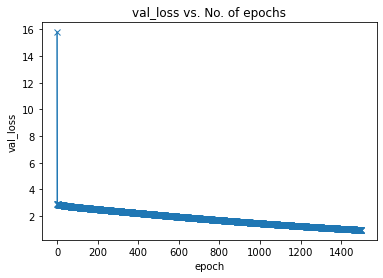

In [60]:
plt.title('val_loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in [result] + history5]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')

val_loss = loss_mat[-1]

In [61]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)#???                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [63]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([12.7000,  0.6000,  0.4900,  2.8000,  0.0750,  5.0000, 19.0000,  0.9994,
         3.1400,  0.5700, 11.4000])
Target: tensor([5.])
Prediction: tensor([5.9881])


In [67]:
input, target = val_ds[62]
predict_single(input, target, model)

Input: tensor([ 9.1000,  0.4500,  0.3500,  2.4000,  0.0800, 23.0000, 78.0000,  0.9987,
         3.3800,  0.6200,  9.5000])
Target: tensor([5.])
Prediction: tensor([5.4455])


In [ ]:
jovian.commit(project=project_name, environment=None)


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
